In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from tqdm.notebook import tqdm
from sklearn import cluster

In [24]:
path = "C:/Users/Acer/Desktop/github/aitu_hackday_rid/data/tifs"

all_data = []
for filename in os.listdir(path):
    filepath = os.path.join(path, filename)
    data = rxr.open_rasterio(filepath)
    all_data.append(data)

In [25]:
all_flat_ndvi_data = []
for data in tqdm(all_data):
    ndvi = es.normalized_diff(data[3], data[0])
    ndvi_data = ndvi.data
    ndvi_data = np.nan_to_num(ndvi_data, nan=-1)
    height = ndvi_data.shape[0]
    width = ndvi_data.shape[1]
    flat_ndvi_data = ndvi_data[:,:].reshape((height*width, 1))
    all_flat_ndvi_data.append(flat_ndvi_data)
    # heigth = raster.height
    # width = raster.width
    # count = raster.count
    # dtype = raster.meta["dtype"]
    # image = np.empty((heigth, width, count), dtype)
    # for band in range(count):
    #     image[:, :, band] = raster.read(band+1)
    # flat_image = image[:, :, :4].reshape((heigth*width, count))
    # flat_images.append(flat_image)

  0%|          | 0/11 [00:00<?, ?it/s]

In [26]:
all_flat_ndvi_data = tuple(all_flat_ndvi_data)
all_flat_ndvi_data = np.r_[all_flat_ndvi_data]

In [27]:
all_flat_ndvi_data.shape

(211640, 1)

In [28]:
model = cluster.KMeans(n_clusters=4, max_iter=1000)
parameters = model.fit(all_flat_ndvi_data)
labels = model.labels_

In [29]:
sorted(model.cluster_centers_.tolist())

[[-1.0000512599945068],
 [0.10563547909259796],
 [0.31969529390335083],
 [0.5072185397148132]]

In [7]:
def cluster(model, flat_data):
    centers = sorted(model.cluster_centers_.tolist())
    grey_range = [-1, centers[1]]
    red_range = [centers[1][0], centers[2][0]]
    yellow_range = [centers[2][0], centers[3][0]]
    green_range = [centers[3][0], 1]
    flat_data[(flat_data>=grey_range[0]) 
               & (flat_data<grey_range[1])] = 1
    flat_data[(flat_data>=red_range[0]) 
               & (flat_data<red_range[1])] = 2
    flat_data[(flat_data>=yellow_range[0]) 
               & (flat_data<yellow_range[1])] = 3
    flat_data[(flat_data>=green_range[0]) 
               & (flat_data<green_range[1])] = 4
    return flat_data

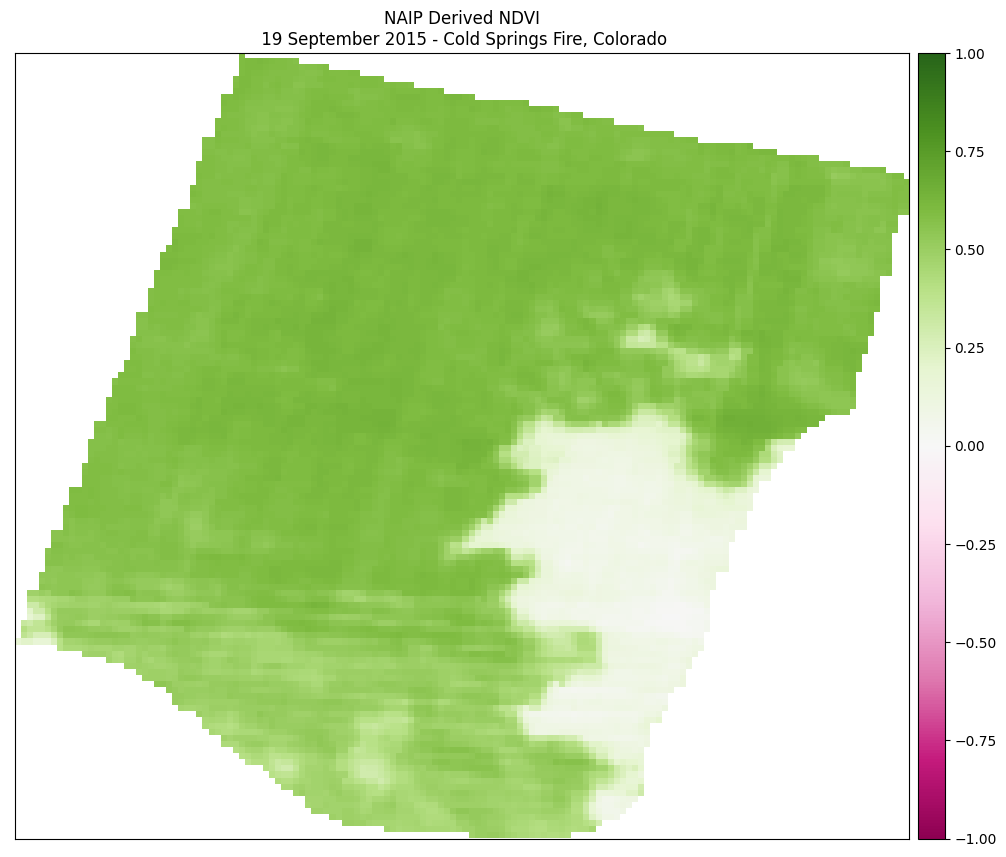

In [18]:
naip_data = rxr.open_rasterio(r"C:\Users\Acer\Desktop\github\aitu_hackday_rid\data\tifs\13-07-2021_8-2.tif")
naip_ndvi = es.normalized_diff(naip_data[3], naip_data[0])
data = naip_ndvi.data
data = np.nan_to_num(data, nan=-1)
flat_data = data[:,:].reshape((data.shape[0]*data.shape[1], 1))
# pred = model.predict(flat_data)
# reshape the 1d array predictions to x-y-bands shape order (only one band)
# elman_cul = pred
# elman_cul = elman_cul.reshape(data[:,:].shape)
ep.plot_bands(naip_ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="NAIP Derived NDVI\n 19 September 2015 - Cold Springs Fire, Colorado")
plt.show()

In [19]:
flat_data = cluster(model, flat_data)

In [20]:
elman_cul = flat_data
elman_cul = elman_cul.reshape(data[:,:].shape)

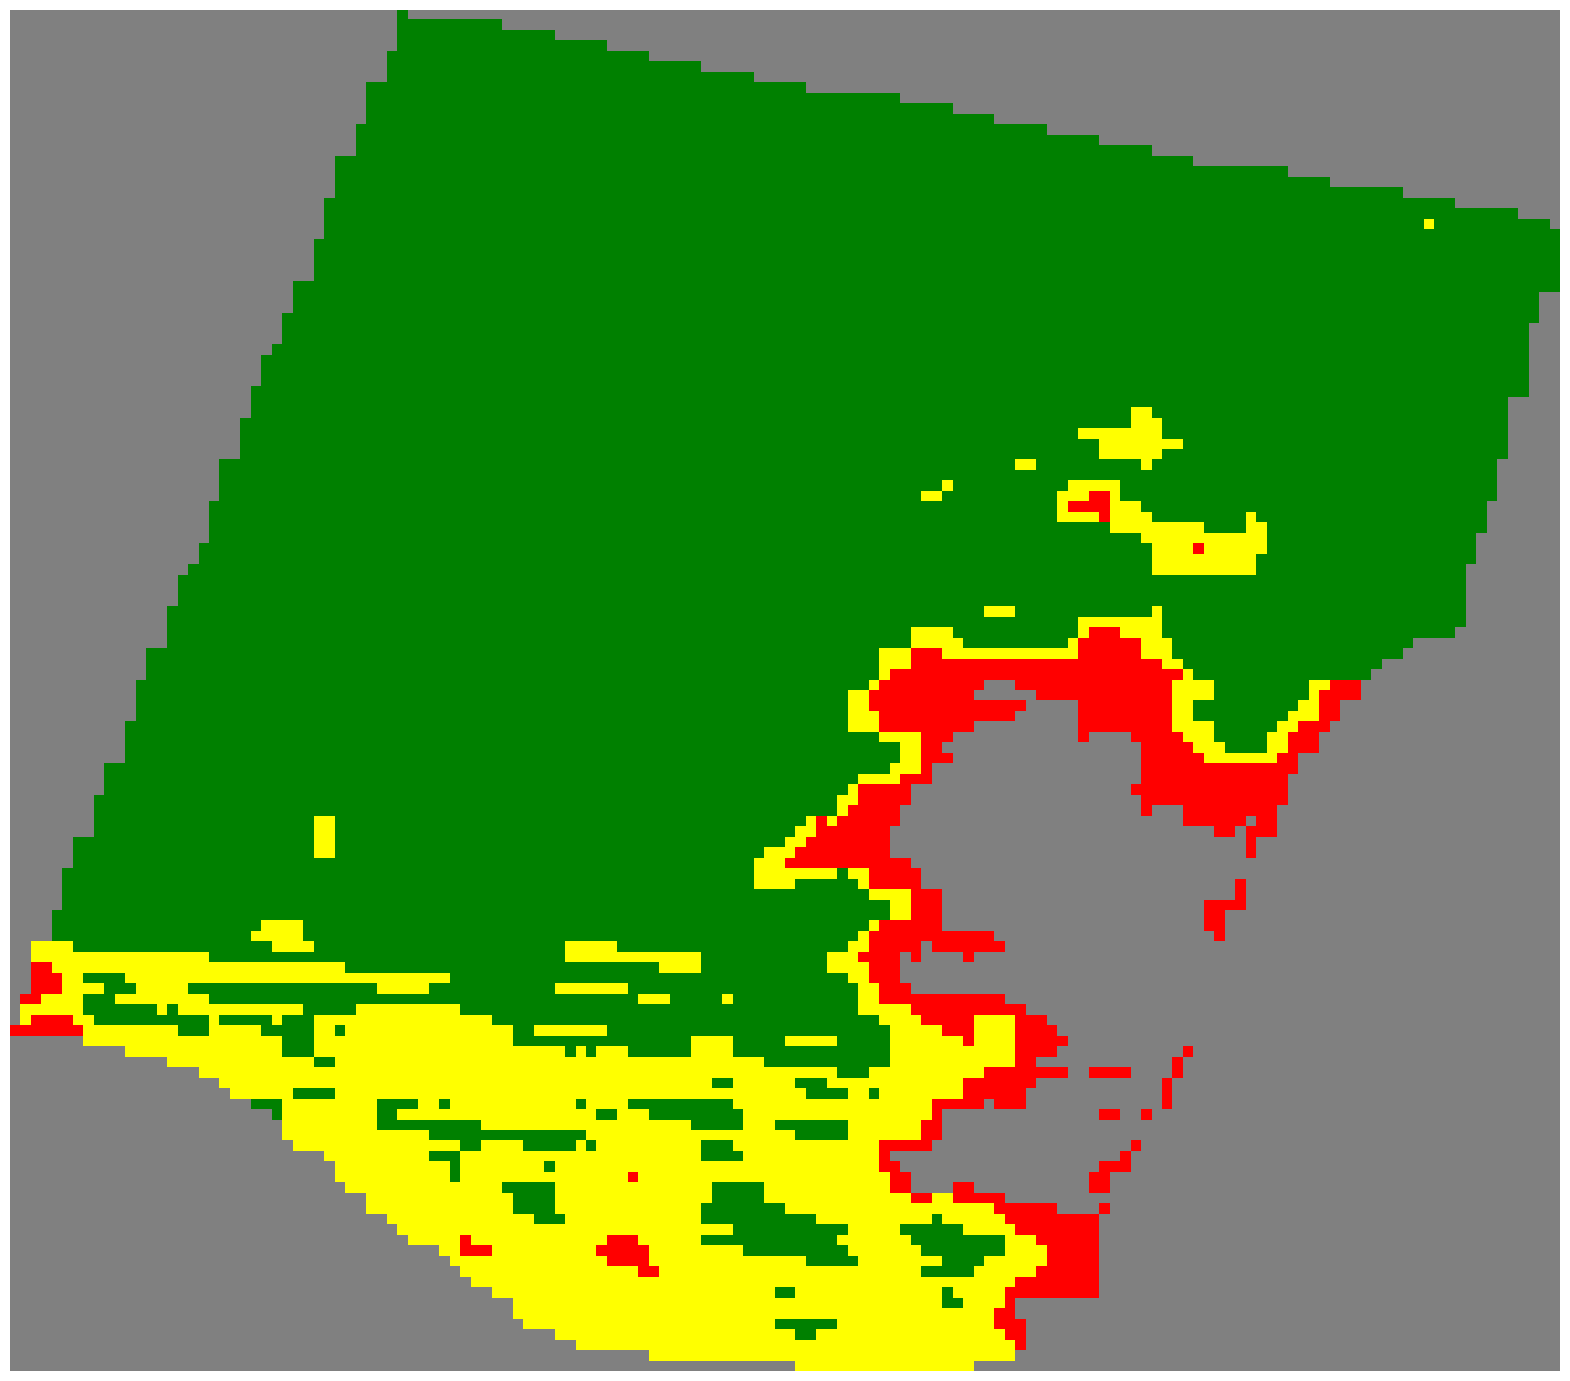

In [21]:
import matplotlib.colors as mc

# Create a custom color map to represent our different 4 classes
cmap = mc.LinearSegmentedColormap.from_list("", ["grey","red","yellow","green"])
# Show the resulting array and save it as jpg image
plt.figure(figsize=[20,20])
plt.imshow(elman_cul, cmap=cmap)
plt.axis('off')
plt.savefig("elhas_clustered.jpg", bbox_inches='tight')
plt.show()

In [12]:
import pickle

with open("rid_model.pkl", "wb") as f:
    pickle.dump(model, f)